In [1]:
import json
import math
import os
import time
import pickle as pkl
import tqdm

import numpy as np
import torch

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

class print_color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import relevant functions from mlpf.pyg
import sys
sys.path.append("/home/jovyan/particleflow/mlpf/")
import pyg
sys.path.append("/home/jovyan/particleflow/mlpf/pyg/")
import utils

from PFDataset import PFDataset, Collater, InterleavedIterator

In [4]:
! ls /pfvol/tensorflow_datasets/clic_edm_ttbar_pf

1.5.0


In [5]:
# define the global base device
world_size = 1
if torch.cuda.device_count():
    rank = 0
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    rank = "cpu"
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA GeForce GTX 1080 Ti


In [6]:
data_dir = "/pfvol/tensorflow_datasets/"
use_cuda = False

In [7]:
def med_iqr(arr):
    if len(arr) > 0:
        p25 = np.percentile(arr, 25)
        p50 = np.percentile(arr, 50)
        p75 = np.percentile(arr, 75)
    else:
        p25 = 0.0
        p50 = 0.0
        p75 = 0.0
    return p50, p75 - p25

# CLIC dataset

In [36]:
! ls /pfvol/tensorflow_datasets/clic*

/pfvol/tensorflow_datasets/clic_edm_qq_pf:
1.5.0

/pfvol/tensorflow_datasets/clic_edm_ttbar_pf:
1.5.0

/pfvol/tensorflow_datasets/clic_edm_ttbar_pu10_pf:
1.5.0

/pfvol/tensorflow_datasets/clic_edm_ww_fullhad_pf:
1.5.0

/pfvol/tensorflow_datasets/clic_edm_zh_tautau_pf:
1.5.0


In [9]:
from pyg.mlpf import MLPF
from pyg.utils import X_FEATURES, Y_FEATURES, unpack_predictions, unpack_target

In [10]:
# we can see the 17th features here (recall type is 1 for tracks and 2 for clusters)
X_FEATURES["clic"]

['type',
 'pt | et',
 'eta',
 'sin_phi',
 'cos_phi',
 'p | energy',
 'chi2 | position.x',
 'ndf | position.y',
 'dEdx | position.z',
 'dEdxError | iTheta',
 'radiusOfInnermostHit | energy_ecal',
 'tanLambda | energy_hcal',
 'D0 | energy_other',
 'omega | num_hits',
 'Z0 | sigma_x',
 'time | sigma_y',
 'Null | sigma_z']

In [11]:
# we can see the 8 gen features per pf element here (notice the jet_index which may be useful)
Y_FEATURES

['cls_id', 'charge', 'pt', 'eta', 'sin_phi', 'cos_phi', 'energy']

In [12]:
def load_checkpoint(checkpoint, model, optimizer=None, key="model_state_dict"):
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model.module.load_state_dict(checkpoint[key])
    else:
        model.load_state_dict(checkpoint[key])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        return model, optimizer
    else:
        return model

# Dataset for training

### MLPF

In [13]:
loaddir = "/pfvol/experiments/MLPF_clic_backbone_8GTX"
    
with open(f"{loaddir}/model_kwargs.pkl", "rb") as f:
    model_kwargs = pkl.load(f)

model_kwargs["attention_type"] = "math"
    
mlpf = MLPF(**model_kwargs)
mlpf.to(rank)

checkpoint = torch.load(f"{loaddir}/best_weights.pth", map_location=torch.device(rank))
mlpf = load_checkpoint(checkpoint, mlpf)

mlpf.eval()

MLPF(
  (nn0_id): Sequential(
    (0): Linear(in_features=17, out_features=512, bias=True)
    (1): ReLU()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
  )
  (nn0_reg): Sequential(
    (0): Linear(in_features=17, out_features=512, bias=True)
    (1): ReLU()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
  )
  (conv_id): ModuleList(
    (0-2): 3 x SelfAttentionLayer(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (norm0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (seq): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): ReLU()
       

### DeepMET

In [14]:
! export TF_CPP_MIN_LOG_LEVEL=3

In [15]:
from met_finetuning_pipeline import DeepMET

PATH_backbone = "/pfvol/experiments/MLPF_clic_backbone_8GTX"

finetuned_models = {
    # pfcands
    "PFcands": "July1_PFCands_1e4_20240701_142328_709653",

    # mlpfcands
    "MLPFcands (fixed)": "July1_MLPFCands_FreezeBackbone_1e4_20240701_142350_081169",    
    "MLPFcands (floating)": "July1_MLPFCands_FloatBackbone_1e6_20240701_142307_285693",
    
#     "MLPFcands (reinitialized)": "July1_MLPFCands_FloatBackbone_ReinitializeBackbone_1e5_20240701_142520_348211",

    # latentx
    "Latents (fixed)": "July1_Latents_FreezeBackbone_1e4_20240701_142608_670362",
    
#     "Latents (floating)": {
#         "PATH_finetuned": "July1_Latents_FloatBackbone_ReinitializeBackbone_1e5_20240701_233855_574958/",
#         "MLPF_mode": "Float",
#     },        
#     "Latents (reinitialized)": {
#         "PATH_finetuned": "July1_Latents_FloatBackbone_ReinitializeBackbone_1e5_20240701_233855_574958",
#         "MLPF_mode": "Float",
#     },  
}

deepmets = {}
for model, PATH_finetuned in finetuned_models.items():
    deepmets[model] = {}
    
    if "Latents" in model:
        indim = 512 + 17 + 6
    elif "MLPF" in model:
        indim = 11
    else:
        indim = 11-5

    checkpoint = torch.load(f"{PATH_backbone}/{PATH_finetuned}/best_weights.pth")

    deepmets[model]["deepmet"] = DeepMET(input_dim=indim).to(rank).eval()    
    deepmets[model]["deepmet"] = load_checkpoint(checkpoint, deepmets[model]["deepmet"], key="deepmet_state_dict")
    
    if model != "PFcands":
        deepmets[model]["mlpf"] = MLPF(**model_kwargs).to(rank).eval()
        deepmets[model]["mlpf"] = load_checkpoint(checkpoint, deepmets[model]["mlpf"], key="mlpf_state_dict")

2024-07-18 15:49:55.488587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 15:49:56.678903: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-07-18 15:49:56.679057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/si

In [17]:
outdir = "/pfvol/plots_foundation_model/METfinetuning_July18"

if not os.path.exists(outdir):
    os.makedirs(outdir)

In [18]:
! ls /pfvol/plots_foundation_model/METfinetuning_July1

clic_edm_ttbar_pf_met_binned.pdf  clic_edm_ttbar_pf_met_M.pdf
clic_edm_ttbar_pf_met_IQR.pdf	  clic_edm_ttbar_pf_METresponse_inclusive.pdf


In [19]:
! rm -rf /pfvol/plots_foundation_model/METfinetuning_July1/*

### Dataset

In [26]:
! du -sh /home/jovyan/particleflow/tensorflow_datasets/

11G	/home/jovyan/particleflow/tensorflow_datasets/


In [27]:
data_dir = "/home/jovyan/particleflow/tensorflow_datasets/"

test_list = {}

sample = "clic_edm_ttbar_pf"

split = "test"
# build dataloader for physical and gun samples seperately
dataset_test = PFDataset(
    data_dir,
    f"{sample}:1.5.0",
    split,
    num_samples=50_000,
    sort="no",
).ds

# build dataloaders
batch_size = 20
loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    collate_fn=Collater(["X", "ygen", "ycand"]),
)
test_list[sample] = []
for i, batch in enumerate(tqdm.tqdm(loader)):
    test_list[sample] += [batch]

INFO:absl:Load dataset info from /home/jovyan/particleflow/tensorflow_datasets/clic_edm_ttbar_pf/1.5.0
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:00<00:00, 10.40it/s]


In [28]:
############################### set up forward hooks if necessary
latent_reps = {}
def get_latent_reps(name):
    def hook(mlpf, input, output):
        latent_reps[name] = output.detach()

    return hook

mlpf.conv_reg[0].dropout.register_forward_hook(get_latent_reps("conv_reg0"))
mlpf.conv_reg[1].dropout.register_forward_hook(get_latent_reps("conv_reg1"))
mlpf.conv_reg[2].dropout.register_forward_hook(get_latent_reps("conv_reg2"))
mlpf.nn_id.register_forward_hook(get_latent_reps("nn_id"))    
###############################
    
MET = {}
MET["gen"], MET["cand"], MET["mlpf"] = [], [], []

for model in finetuned_models:
    MET[model] = []

wxs, wys = [], []

for i, batch in enumerate(tqdm.tqdm(test_list[sample])):
    
    batch = batch.to(rank)
    
    ygen = unpack_target(batch.ygen)
    ycand = unpack_target(batch.ycand)

    ####################### MET from gen
    msk_gen = (ygen["cls_id"] != 0)
    gen_px = (ygen["pt"] * ygen["cos_phi"]) * msk_gen
    gen_py = (ygen["pt"] * ygen["sin_phi"]) * msk_gen
    MET["gen"] += torch.sqrt(torch.sum(gen_px, axis=1) ** 2 + torch.sum(gen_py, axis=1) ** 2).tolist()
    
    ####################### MET from PFcand
    msk_cand = (ycand["cls_id"] != 0)
    cand_px = (ycand["pt"] * ycand["cos_phi"]) * msk_cand
    cand_py = (ycand["pt"] * ycand["sin_phi"]) * msk_cand
    MET["cand"] += torch.sqrt(torch.sum(cand_px, axis=1) ** 2 + torch.sum(cand_py, axis=1) ** 2).tolist()  
    
    ####################### MET from MLPF 
    with torch.autocast("cuda", dtype=torch.float32, enabled=True):
        with torch.no_grad():
            ymlpf = mlpf(batch.X, batch.mask)    
    ymlpf = unpack_predictions(ymlpf)
    
    msk_ymlpf = (ymlpf["cls_id"] != 0)
    pred_px = ((ymlpf["pt"] * ymlpf["cos_phi"]) * msk_ymlpf).cpu()
    pred_py = ((ymlpf["pt"] * ymlpf["sin_phi"]) * msk_ymlpf).cpu()
    
    MET["mlpf"] += torch.sqrt(torch.sum(pred_px, axis=1) ** 2 + torch.sum(pred_py, axis=1) ** 2).tolist()   
    
    ####################### MET from finetuning    

    for model in finetuned_models:
        
        # models that use MLPFcands/Latents
        if model != "PFcands":
            with torch.autocast("cuda", dtype=torch.float32, enabled=True):
                with torch.no_grad():
                    ymlpf = deepmets[model]["mlpf"](batch.X, batch.mask)    
            ymlpf = unpack_predictions(ymlpf)

            msk_ymlpf = (ymlpf["cls_id"] != 0)
            pred_px = ((ymlpf["pt"] * ymlpf["cos_phi"]) * msk_ymlpf).cpu()
            pred_py = ((ymlpf["pt"] * ymlpf["sin_phi"]) * msk_ymlpf).cpu()

            if "Latents" in model:        
                X = torch.cat(
                    [
                        batch.X,  # 17
                        latent_reps["conv_reg2"],  # 256
                        latent_reps["nn_id"],  # 6
                    ],
                    axis=-1,
                )
            else:
                X = torch.cat([ymlpf["momentum"], ymlpf["cls_id_onehot"]], axis=-1)

            X = X * msk_ymlpf.unsqueeze(-1)  # run DeepMET on actual particles (i.e. ignore the Nulls)    

        else:
            # models that use PFcands
            msk_ycand = ycand["cls_id"] != 0
            pred_px = ((ycand["pt"] * ycand["cos_phi"]) * msk_ycand).cpu()
            pred_py = ((ycand["pt"] * ycand["sin_phi"]) * msk_ycand).cpu()

            X = torch.cat([ycand["momentum"], ycand["cls_id"].unsqueeze(-1)], axis=-1)
            X = X * msk_ycand.unsqueeze(-1)  # run downstream on actual particles (i.e. ignore the Nulls)

        w = deepmets[model]["deepmet"](X).detach().cpu()

        pred_met = (torch.sum(w * pred_px, axis=1) ** 2) + (torch.sum(w * pred_py, axis=1) ** 2)
        MET[model] += torch.sqrt(pred_met).tolist()

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:11<00:00,  6.72it/s]


In [29]:
for key in MET:
    MET[key] = np.array(MET[key])

In [ ]:
for m in MET:
#     MET[m] = MET[m][:13440]
    print(m, MET[m].shape)

# Plots

In [30]:
# from plotting.plot_utils import labels, sample_label

EVALUATION_DATASET_NAMES = {
    "delphes_ttbar_pf": r"Delphes-CMS $pp \rightarrow \mathrm{t}\overline{\mathrm{t}}$",
    "delphes_qcd_pf": r"Delphes-CMS $pp \rightarrow \mathrm{QCD}$",
    "clic_edm_ttbar_pf": r"$e^+e^- \rightarrow \mathrm{t}\overline{\mathrm{t}}$",
    "clic_edm_ttbar_pu10_pf": r"$e^+e^- \rightarrow \mathrm{t}\overline{\mathrm{t}}$, PU10",
    "clic_edm_ttbar_hits_pf": r"$e^+e^- \rightarrow \mathrm{t}\overline{\mathrm{t}}$",
    "clic_edm_qq_pf": r"$e^+e^- \rightarrow \gamma/\mathrm{Z}^* \rightarrow \mathrm{hadrons}$",
    "clic_edm_ww_fullhad_pf": r"$e^+e^- \rightarrow WW \rightarrow \mathrm{hadrons}$",
    "clic_edm_zh_tautau_pf": r"$e^+e^- \rightarrow ZH \rightarrow \tau \tau$",
    "cms_pf_qcd": r"QCD $p_T \in [15, 3000]\ \mathrm{GeV}$+PU",
    "cms_pf_ztt": r"$\mathrm{Z}\rightarrow \mathrm{\tau}\mathrm{\tau}$+PU",
    "cms_pf_ttbar": r"$\mathrm{t}\overline{\mathrm{t}}$+PU",
    "cms_pf_multi_particle_gun": r"multi particle gun events",
    "cms_pf_single_electron": r"single electron particle gun events",
    "cms_pf_single_gamma": r"single photon gun events",
    "cms_pf_single_mu": r"single muon particle gun events",
    "cms_pf_single_pi": r"single pion particle gun events",
    "cms_pf_single_pi0": r"single neutral pion particle gun events",
    "cms_pf_single_proton": r"single proton particle gun events",
    "cms_pf_single_tau": r"single tau particle gun events",
    "cms_pf_sms_t1tttt": r"sms t1tttt events",
}

def sample_label(ax, sample, additional_text="", x=0.03, y=0.97, c="black"):
    text = EVALUATION_DATASET_NAMES[sample]
    plt.text(x, y, text + additional_text, ha="left", va="top", transform=ax.transAxes, color=c)

labels = {
    "met": "$p_{\mathrm{T}}^{\mathrm{miss}}$ [GeV]",
    "gen_met": "$p_{\mathrm{T,truth}}^\mathrm{miss}$ [GeV]",
    "gen_mom": "$p_{\mathrm{truth}}$ [GeV]",
    "gen_jet": "jet $p_{\mathrm{T,truth}}$ [GeV]",
    "gen_jet_eta": "jet $\eta_{\mathrm{truth}}$ [GeV]",
    "reco_met": "$p_{\mathrm{T,reco}}^\mathrm{miss}$ [GeV]",
    "reco_gen_met_ratio": "$p_{\mathrm{T,reco}}^\mathrm{miss} / p_{\\mathrm{T,truth}}^\mathrm{miss}$",
    "reco_gen_mom_ratio": "$p_{\mathrm{reco}} / p_{\\mathrm{truth}}$",
    "reco_gen_jet_ratio": "jet $p_{\mathrm{T,reco}} / p_{\\mathrm{T,truth}}$",
    "gen_met_range": "${} \less p_{{\mathrm{{T,truth}}}}^\mathrm{{miss}}\leq {}$",
    "gen_mom_range": "${} \less p_{{\mathrm{{truth}}}}\leq {}$",
    "gen_jet_range": "${} \less p_{{\mathrm{{T,truth}}}} \leq {}$",
    "gen_jet_range_eta": "${} \less \eta_{{\mathrm{{truth}}}} \leq {}$",

    # added by farouk
    "reco_met": "$p_{\mathrm{T,reco}}^\mathrm{miss}$ [GeV]",    
}

M 25


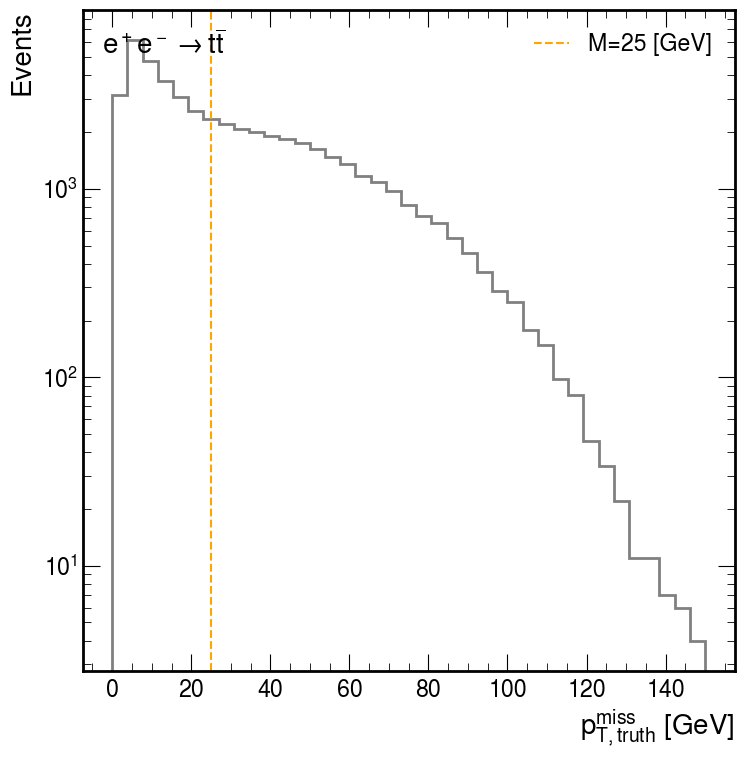

In [125]:
fig, ax = plt.subplots(figsize=(8,8))

bins = np.linspace(0,150,40)
        
X = MET["gen"]
p = math.floor(med_iqr(X)[0])
print("M", p)
ax.hist(X, bins, histtype="step", lw=2, color="grey")

ax.set_xlabel(labels["gen_met"])
ax.set_ylabel("Events")
# ax.set_yscale("log")

ax.axvline(25, linestyle="--", color="orange", label="M=25 [GeV]")
ax.legend()

sample_label(ax, sample)
             
plt.tight_layout()

ax.set_yscale("log")

plt.savefig(f"{outdir}/{sample}_MET.pdf")

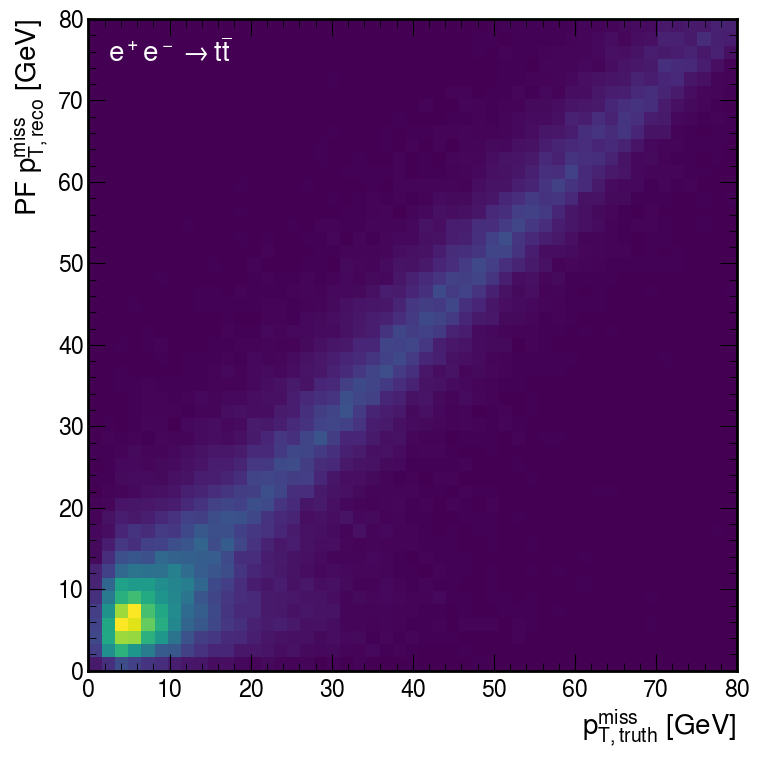

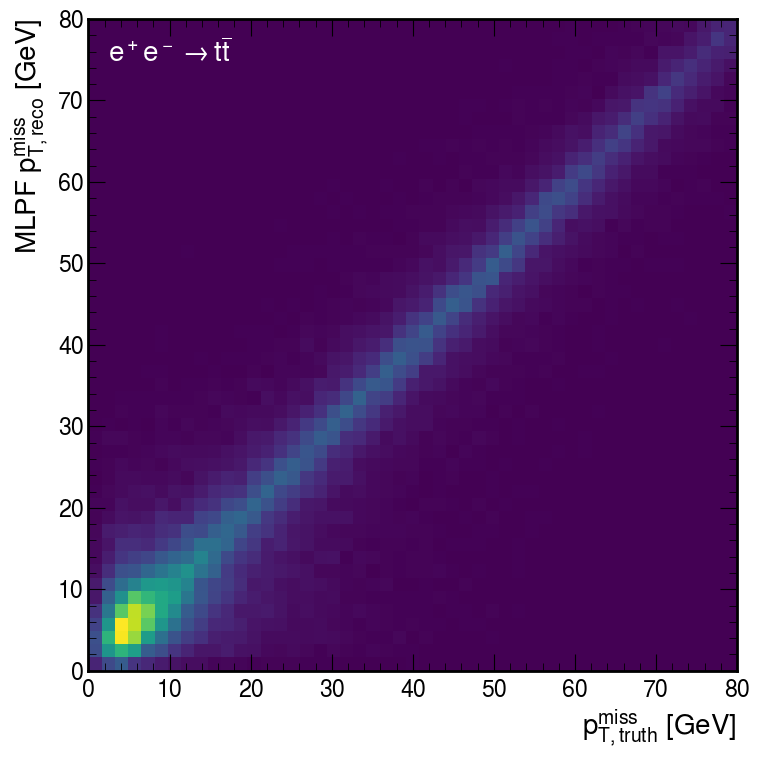

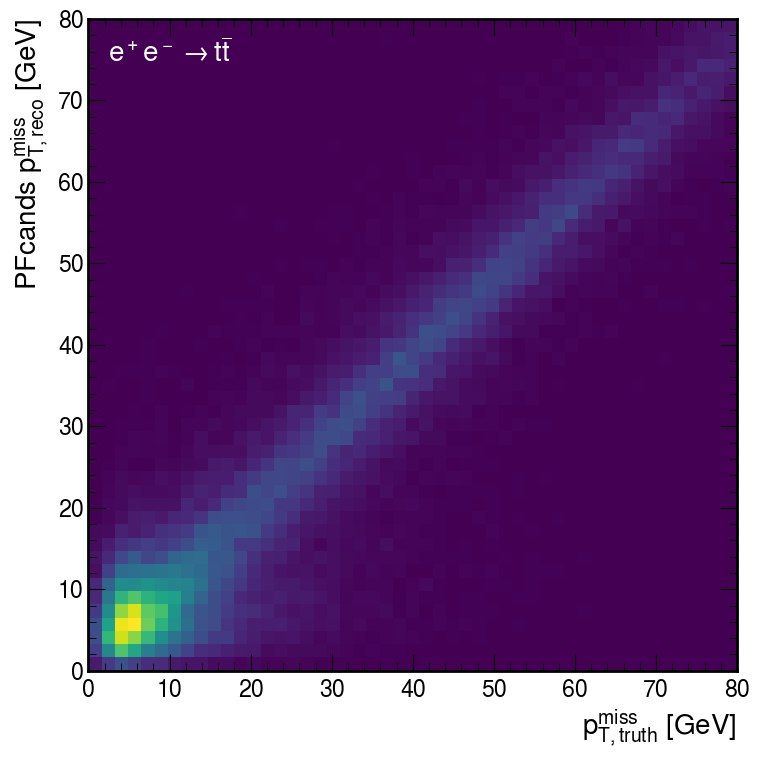

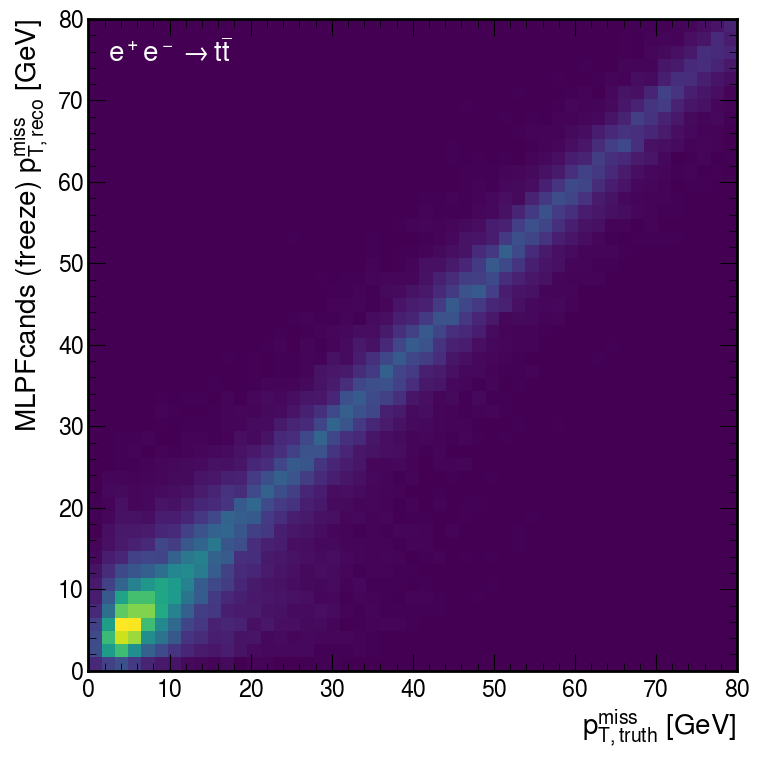

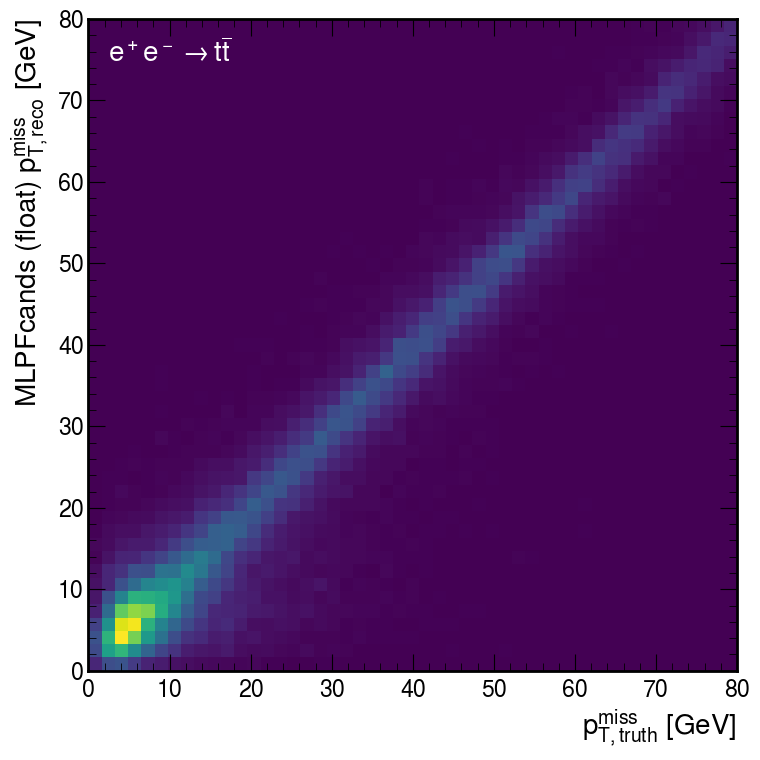

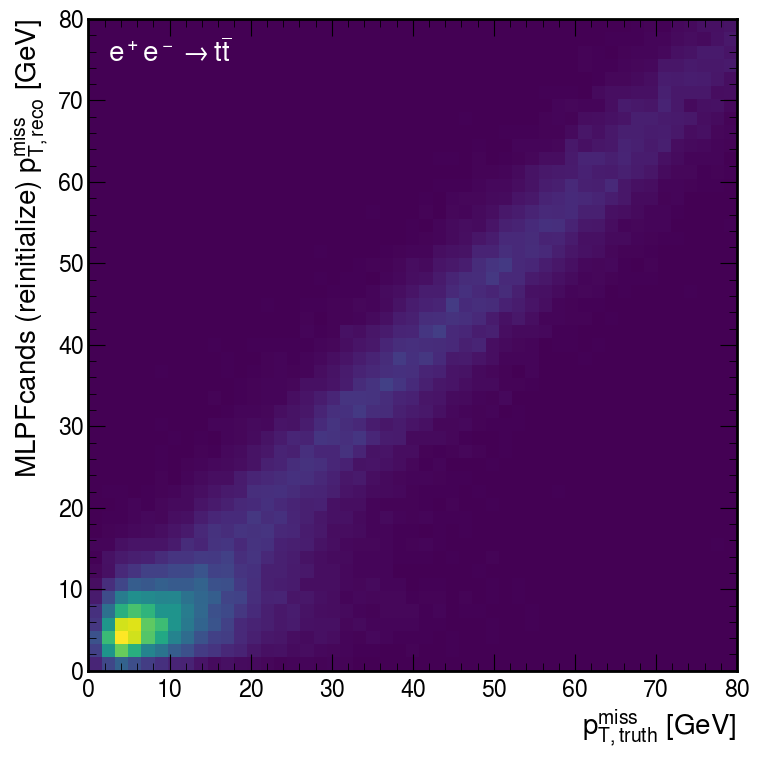

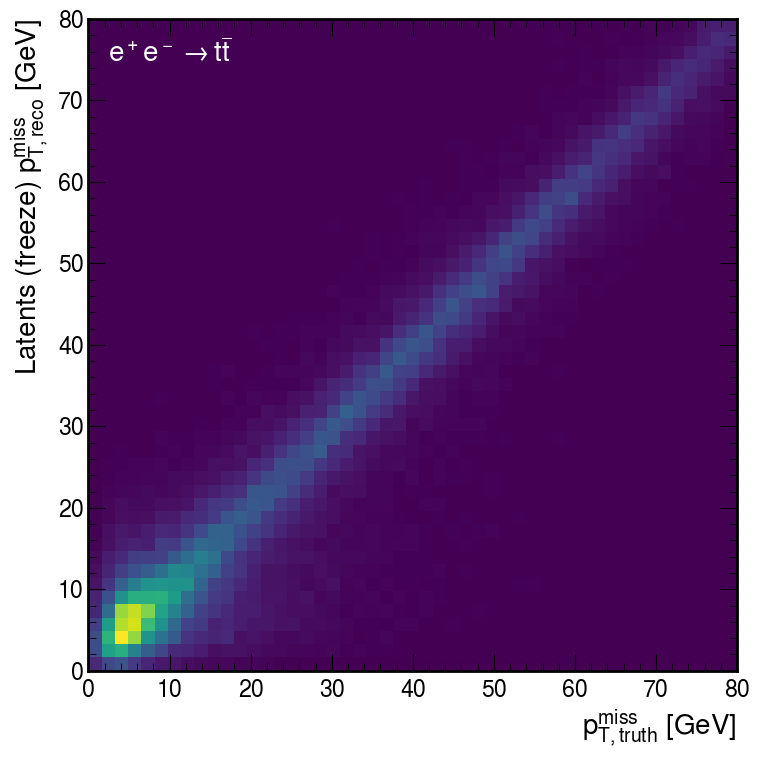

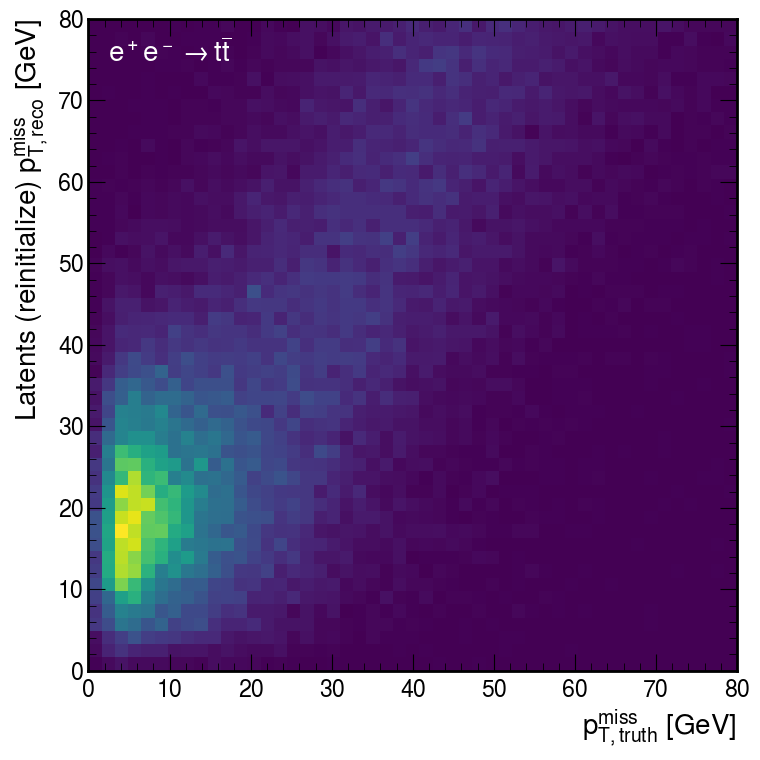

In [45]:
reco_dict = {
    "PF": MET["cand"],
    "MLPF": MET["mlpf"],

    "PFcands": MET["PFcands"],

    "MLPFcands (freeze)": MET["MLPFcands (freeze)"],
    "MLPFcands (float)": MET["MLPFcands (float)"],
    "MLPFcands (reinitialize)": MET["MLPFcands (reinitialize)"],

    "Latents (freeze)": MET["Latents (freeze)"],
#     "Latents (float)": MET["Latents (float)"],
    "Latents (reinitialize)": MET["Latents (reinitialize)"],
}

bins = np.linspace(0,80,50)

for reco_label, reco_arr in reco_dict.items():
    fig, ax = plt.subplots(figsize=(8,8))

    ax.hist2d(MET["gen"], reco_arr, bins)
#     ax.set_title(reco_label, pad=20, fontsize=20)
    ax.set_xlabel(labels["gen_met"])
    ax.set_ylabel(reco_label + " " + labels["reco_met"])

    sample_label(ax, sample, c="white")

    plt.tight_layout()
    plt.savefig(f"{outdir}/2dcorrelation_{sample}_{reco_label}.pdf")

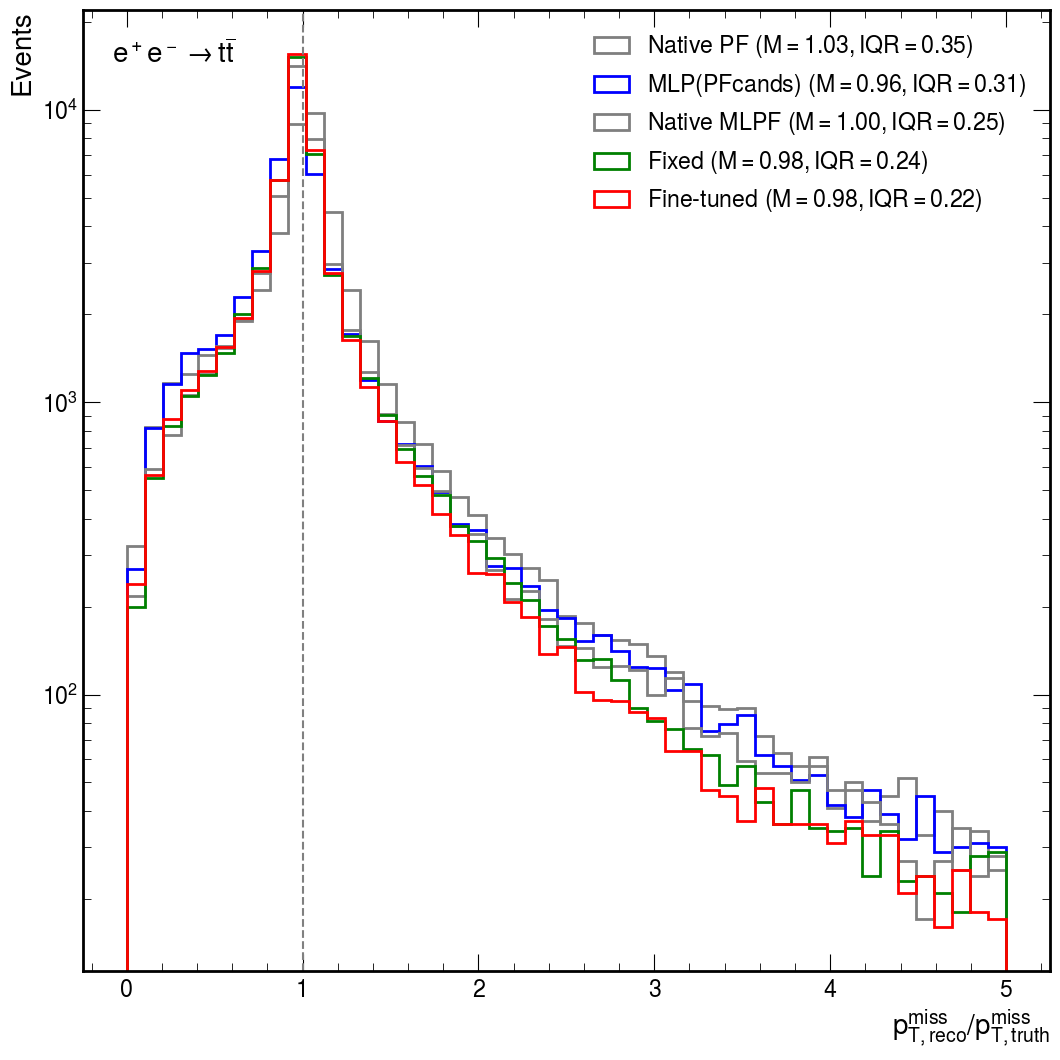

In [49]:
fig, ax = plt.subplots(figsize=(11,11))

msk_dict = {
    "inclusive": {
        "label": "",
        "msk": MET["gen"]>0,
        "bin": np.linspace(0,5,50),
        "yrange": 14000,
    },
    "low": {
        "label": "\n 0" + labels["gen_met_range"] + "25",
        "msk": MET["gen"]<25,
        "bin": np.linspace(0,5,50),
        "yrange": 2000,
    },
    "high": {
        "label": "\n 25" + labels["gen_met_range"] + "200",
        "msk": MET["gen"]>25,
        "bin": np.linspace(0,5,50),
        "yrange": 12000,        
    },
}
    
reco_dict = {    
    "Native PF": (MET["cand"], "tab:grey"),
    "MLP(PFcands)": (MET["PFcands"], "blue"),
    
    "Native MLPF": (MET["mlpf"], "tab:grey"),
    "Fixed": (MET["MLPFcands (fixed)"], "green"),
    "Fine-tuned": (MET["MLPFcands (floating)"], "red"),
#     "From scratch": (MET["MLPFcands (reinitialized)"], "blue"),
    
#     "Latents (fixed)": MET["Latents (fixed)"],
#     "Latents (float)": MET["Latents (float)"],
#     "Latents (reinitialize)": MET["Latents (reinitialized)"],
}


which_msk = "inclusive"

for reco_label, (reco_arr, c) in reco_dict.items():      
    X = reco_arr[msk_dict[which_msk]["msk"]]/MET["gen"][msk_dict[which_msk]["msk"]]
    p = med_iqr(X)
    ax.hist(
        X, 
        msk_dict[which_msk]["bin"], 
        histtype="step", 
        lw=2,
        color=c,
        label=reco_label + " $(M={:.2f}, IQR={:.2f})$".format(p[0], p[1]),
    )

ax.axvline(1, linestyle="--", color="grey");
ax.legend(loc="upper right")#, bbox_to_anchor=(1, 0.8))
sample_label(ax, sample, additional_text=msk_dict[which_msk]["label"])
ax.set_xlabel(labels["reco_gen_met_ratio"])
ax.set_ylabel("Events");

# ax.set_ylim(0,msk_dict[which_msk]["yrange"])
    
ax.set_yscale("log")

plt.tight_layout()
plt.savefig(f"{outdir}/{sample}_METresponse_{which_msk}.pdf")

In [31]:
def plot_met_resolution(reco_dict, gen_arr, sample):
    """Copied from here https://github.com/jpata/particleflow/blob/main/mlpf/plotting/plot_utils.py#L1260.
    
    reco_dict [dict]: (key [str] = the label (e.g. PF, MLPF), value [np.array] = the reco values)
    gen_arr [np.array]: the gen values
    sample [str]: dataset label

    """    

#     bins = [0, 10, 20, 40, 60, 80, 150]   # atm must be 6 bins for corresponding to the 6 subplots
    
    
    bins = [0, 5, 10, 15, 20, 25, 40, 60, 80, 150]   # atm must be 6 bins for corresponding to the 6 subplots    
    
#     fig, axs = plt.subplots(2, 3, figsize=(3 * 5, 2 * 5))
    fig, axs = plt.subplots(3, 3, figsize=(3 * 5, 3 * 5))

    x_vals, reco_vals = {}, {}
    
    for reco_label, (reco_arr, c) in reco_dict.items():
        x_vals[reco_label], reco_vals[reco_label] = [], []
        
        response = reco_arr/gen_arr

        b = np.linspace(0, 5, 50)

        axs = axs.flatten()
        for ibin in range(len(bins) - 1):
            lim_low = bins[ibin]
            lim_hi = bins[ibin + 1]
            x_vals[reco_label].append(np.mean([lim_low, lim_hi]))

            mask_genjet = (reco_arr > lim_low) & (reco_arr <= lim_hi)
            subsample = response[mask_genjet]
            if len(subsample) > 0:
                reco_p25 = np.percentile(subsample, 25)
                reco_p50 = np.percentile(subsample, 50)
                reco_p75 = np.percentile(subsample, 75)
            else:
                reco_p25 = 0
                reco_p50 = 0
                reco_p75 = 0
            reco_vals[reco_label].append([reco_p25, reco_p50, reco_p75])

            plt.sca(axs[ibin])
            plt.hist(subsample, bins=b, histtype="step", lw=2, label=reco_label, color=c)
            plt.ylabel("Events / bin")
            plt.xlabel(labels["reco_gen_met_ratio"])
            plt.axvline(1.0, ymax=0.7, color="black", ls="--")
            plt.legend(loc=1, fontsize=16)
            plt.title(labels["gen_met_range"].format(lim_low, lim_hi))
            plt.yscale("log")

        x_vals[reco_label] = np.array(x_vals[reco_label])
        reco_vals[reco_label] = np.array(reco_vals[reco_label])
            
    plt.tight_layout()
    plt.savefig(f"{outdir}/{sample}_met_binned.pdf")
    
    # Plot Median of gen pt
    plt.figure(figsize=(8,8))    
    ax = plt.gca()
    for reco_label, (reco_arr, c) in reco_dict.items():
        plt.plot(x_vals[reco_label], reco_vals[reco_label][:, 1], marker="o", label=reco_label, color=c)
    plt.legend(loc=1, fontsize=16)
    plt.ylabel("Response median")
    plt.xlabel(labels["gen_met"])
    plt.tight_layout()
    plt.axhline(1.0, color="black", ls="--", lw=0.5)
    plt.ylim(0.4,1.2)
    sample_label(ax, sample)
    plt.savefig(f"{outdir}/{sample}_met_M.pdf")    

    # Plot IQR/M as a function of gen pt    
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    for reco_label, (reco_arr, c) in reco_dict.items():
        plt.plot(x_vals[reco_label], (reco_vals[reco_label][:, 2] - reco_vals[reco_label][:, 0]) / reco_vals[reco_label][:, 1], marker="o", label=reco_label, color=c)
    plt.legend(loc=1, fontsize=16)
    plt.ylabel("Response IQR / median")
    plt.xlabel(labels["gen_met"])
    plt.tight_layout()
    plt.ylim(0,1.4)    
    sample_label(ax, sample)
    plt.savefig(f"{outdir}/{sample}_met_IQR.pdf")

In [34]:
reco_dict = {    
    "Native PF": (MET["cand"], "black"),
#     "MLP(PFcands)": (MET["PFcands"], "blue"),

    "Native MLPF": (MET["mlpf"], "tab:grey"),    
    
    "Baseline": (MET["PFcands"], "blue"),    
    "Fixed": (MET["MLPFcands (fixed)"], "green"),
    "Fine-tuned": (MET["MLPFcands (floating)"], "red"),

    
#     "From scratch": (MET["MLPFcands (reinitialized)"], "blue"),
    
#     "Latents (fixed)": MET["Latents (fixed)"],
#     "Latents (float)": MET["Latents (float)"],
#     "Latents (reinitialize)": MET["Latents (reinitialized)"],
}


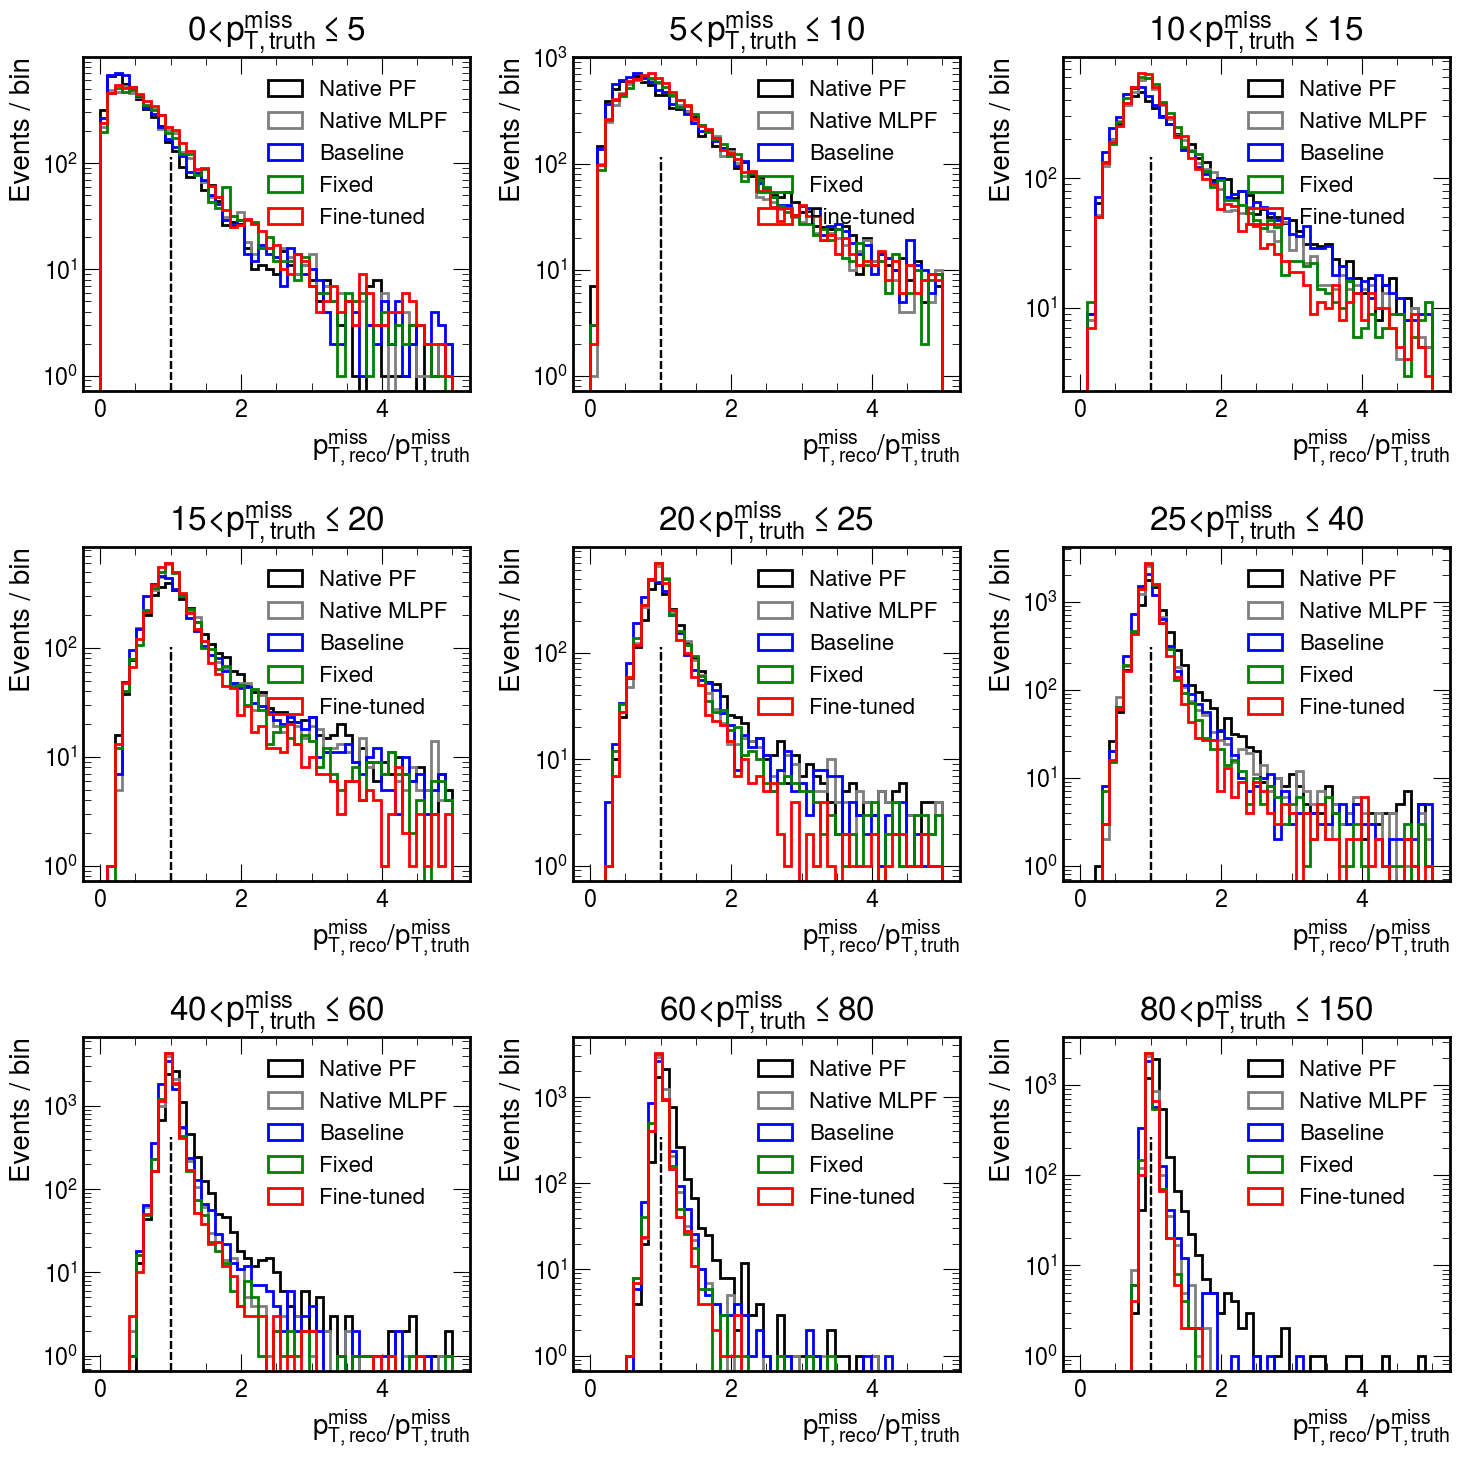

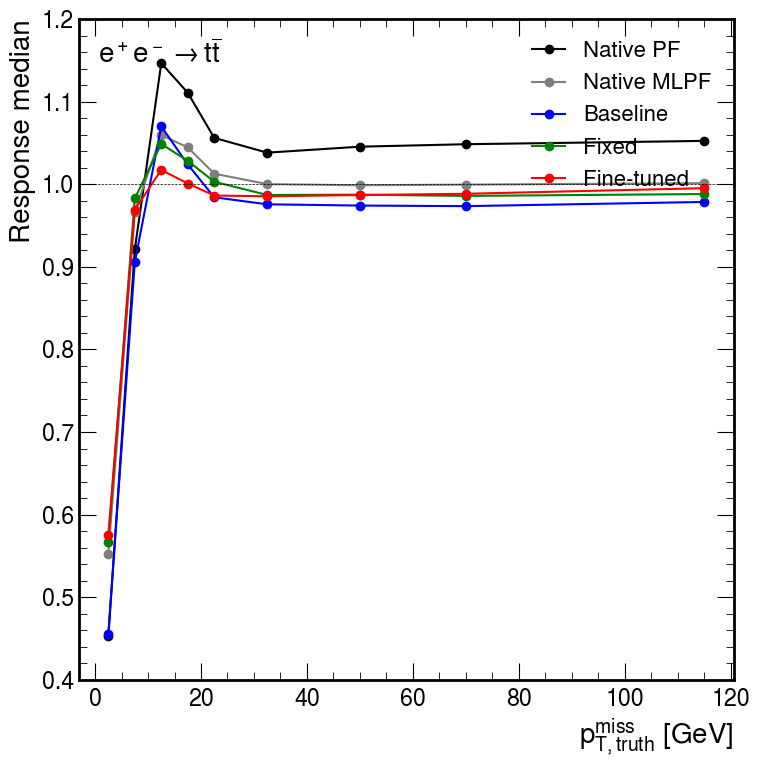

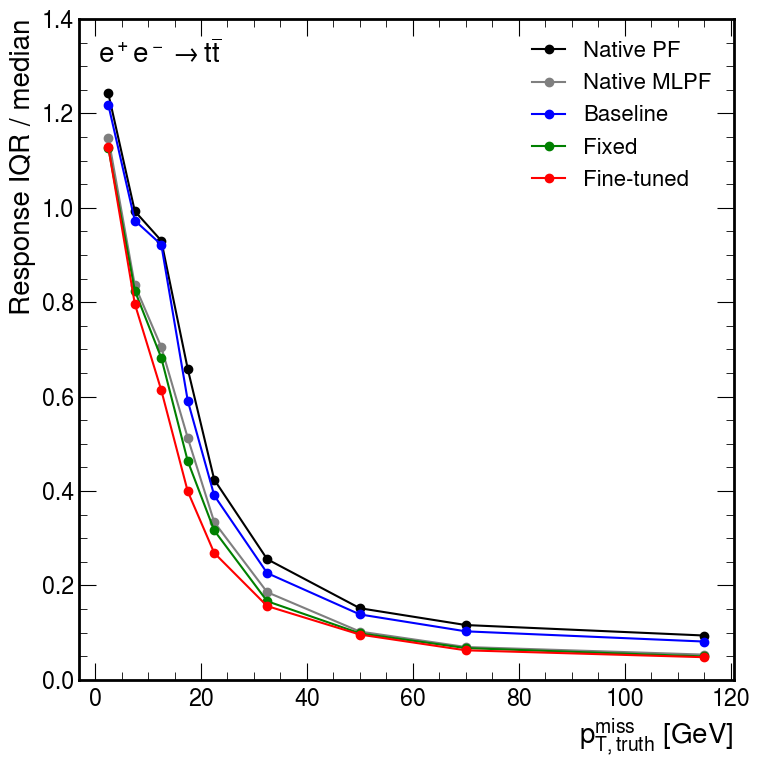

In [35]:
plot_met_resolution(reco_dict, MET["gen"], sample)